# Preprocessing

In [1]:
%run project_functions.ipynb

Using TensorFlow backend.


In [2]:
file_name = 'FB.json'
csv_name = 'FB.csv'

In [3]:
#Features
company = stock_twits_text_parser(file_name)
company_metrics = stock_twits_metrics(company, 3, file_name)

#Labels
company_return = return_over_period_T(csv_name,3)

#Cleaned Data
agg_data = feature_selector(company_metrics, company_return, 'close_return', 25, 1000)
company_data = split_data(agg_data, 0.7, 'all', 'close_return', 'cont')

#Split
X_train = company_data['X_train']
Y_train = company_data['Y_train']
X_test = company_data['X_test']
Y_test = company_data['Y_test']


# KNN Regression

In [4]:
# Find best model
model = get_best_knn_regressor(5, 30, 1, 5, X_train, Y_train)

# training and test predictions
pred_train_knn = model.predict(X_train)
pred_test_knn = model.predict(X_test)


Best Parameters: 
{'n_neighbors': 30, 'p': 2, 'weights': 'uniform'}


# Action Signal Mapping

- 1 = Positive Action
- 0 = No Action
- -1 = Negative Action

In [5]:
action_signal_train = np.copy(Y_train)
action_signal_train[action_signal_train < -.005] = -1
action_signal_train[action_signal_train > .005] = 1
action_signal_train[np.abs(action_signal_train) <= .005] = 0

action_signal_test = np.copy(Y_test)
action_signal_test[action_signal_test < -.005] = -1
action_signal_test[action_signal_test > .005] = 1
action_signal_test[np.abs(action_signal_test) <= .005] = 0

action_signal_predict_train = np.copy(pred_train_knn)
action_signal_predict_train[action_signal_predict_train < -.005] = -1
action_signal_predict_train[action_signal_predict_train > .005] = 1
action_signal_predict_train[np.abs(action_signal_predict_train) <= .005] = 0

action_signal_predict_test = np.copy(pred_test_knn)
action_signal_predict_test[action_signal_predict_test < -.005] = -1
action_signal_predict_test[action_signal_predict_test > .005] = 1
action_signal_predict_test[np.abs(action_signal_predict_test) <= .005] = 0


# Classification Metrics

- Note: The cases detected as no action are not considered in these metrics

In [6]:
action_signal_train_metrics = np.empty((action_signal_train.shape))
action_signal_test_metrics = np.empty((action_signal_test.shape))
action_signal_predict_train_metrics = np.empty((action_signal_predict_train.shape))
action_signal_predict_test_metrics = np.empty((action_signal_predict_test.shape))

train_len = action_signal_train.shape[0]
test_len = action_signal_test.shape[0]

for i in range(0, train_len):
    if (np.abs(action_signal_train[i] + action_signal_predict_train[i]) == 1) or (action_signal_train[i] == 0 and action_signal_predict_train[i] == 0):
        action_signal_train_metrics[i] = 0
        action_signal_predict_train_metrics[i] = 0
    else:
        action_signal_train_metrics[i] = action_signal_train[i]
        action_signal_predict_train_metrics[i] = action_signal_predict_train[i]



for j in range(0, test_len):
    if (np.abs(action_signal_test[j] + action_signal_predict_test[j]) == 1) or (action_signal_test[j] == 0 and action_signal_predict_test[j] == 0):
        action_signal_test_metrics[j] = 0
        action_signal_predict_test_metrics[j] = 0
    else:
        action_signal_test_metrics[j] = action_signal_test[j]
        action_signal_predict_test_metrics[j] = action_signal_predict_test[j]


In [7]:
action_signal_train_metrics =  action_signal_train_metrics[action_signal_train_metrics != 0]
action_signal_test_metrics =  action_signal_test_metrics[action_signal_test_metrics != 0]
action_signal_predict_train_metrics = action_signal_predict_train_metrics[action_signal_predict_train_metrics != 0]
action_signal_predict_test_metrics = action_signal_predict_test_metrics[action_signal_predict_test_metrics != 0]

In [8]:
cm_action_signal_train = confusion_matrix(action_signal_train_metrics,action_signal_predict_train_metrics)
cm_action_signal_test = confusion_matrix(action_signal_test_metrics,action_signal_predict_test_metrics)

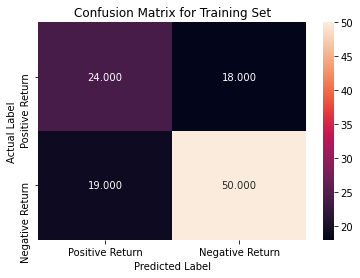

In [9]:
plot_confusion_matrix(cm_action_signal_train, "Training")

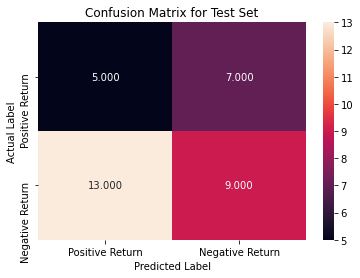

In [10]:
plot_confusion_matrix(cm_action_signal_test, "Test")

In [11]:
table = create_metrics_table(action_signal_train_metrics, action_signal_predict_train_metrics, action_signal_test_metrics, action_signal_predict_test_metrics)
table

,Recall,Precision,F1 Score,Accuracy
Dataset,,,,
Training,0.724638,0.735294,0.729927,0.666667
Test,0.409091,0.562500,0.473684,0.411765
